In [1]:
!pip install ripser
!pip install opfunu

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 834.5/834.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 37.9 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18102 sha256=d6700288039dc6bb5bb76f9a8d321b00ec2f3948553a1afa4f2b39b33de70ec9
  Stored in directory: /home/jovyan/.cache/pip/wheels/ef/0f/3b/0f931844eecc34addd90e72d54cd39c08b7066c5f25c00b9a4
Successfully built hopcroftkarp
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 7.5 MB/s eta 0:00:00a 0:00:01


In [2]:
import opfunu
from pymoo.problems import get_problem
from tqdm import tqdm
import pandas as pd
from utils import *
from pymoo.vendor.vendor_coco import COCOProblem
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import time

from ripser import ripser
from persim import plot_diagrams

In [3]:
def generate_points_on_line(start_point, end_point, num_points):
    t_values = np.linspace(0, 1, num_points)
    start_point = np.array(start_point)
    end_point = np.array(end_point)
    points_on_line = start_point + t_values[:, np.newaxis] * (end_point - start_point)
    return points_on_line

def diagram_points(x):
    N = len(x)
    I = np.arange(N-1)
    J = np.arange(1, N)
    V = np.maximum(x[0:-1], x[1::])
    I = np.concatenate((I, np.arange(N)))
    J = np.concatenate((J, np.arange(N)))
    V = np.concatenate((V, x))
    #Create the sparse distance matrix
    D = sparse.coo_matrix((V, (I, J)), shape=(N, N)).tocsr()
    dgm0 = ripser(D, maxdim=0, distance_matrix=True)['dgms'][0]
    dgm0 = dgm0[dgm0[:, 1]-dgm0[:, 0] > 1e-3, :]
    allgrid = np.unique(dgm0.flatten())
    allgrid = allgrid[allgrid < np.inf]
    xs = np.unique(dgm0[:, 0])
    ys = np.unique(dgm0[:, 1])
    ys = ys[ys < np.inf]
    return xs, ys, dgm0

In [4]:
functions = opfunu.get_cec_based_functions(ndim=2)

In [5]:
num_points = 2000

# Line search

In this case, we take a 2D CEC function and perform a line search over the diagonal. Below are the plots for the lines obtained by following the diagonal line from start to end with num_points samples, together with persistence diagrams and bar plots sorted by a) birth time, b) death time, and c) lifetime (death - birth).

In [6]:
def c1_sort(arr):
    arr = np.asarray(arr)
    sorted_arr = arr[arr[:, 0].argsort()]
    return sorted_arr

def c2_sort(arr):
    arr = np.asarray(arr)
    sorted_arr = arr[arr[:, 1].argsort()]
    return sorted_arr

def l_sort(arr):
    arr = np.asarray(arr)
    abs_diff = np.abs(arr[:, 0] - arr[:, 1])
    sorted_indices = np.argsort(abs_diff)
    sorted_arr = arr[sorted_indices]
    return sorted_arr

The file named: rastrigin_M_D2.txt is not found.
F102005 problem is only supported ndim in [10, 30, 50]!
The file named: shift_data_10_D2.txt is not found.
F102015 problem is only supported ndim in [10, 30]!
The file named: weierstrass_M_D2.txt is not found.
F112005 problem is only supported ndim in [10, 30, 50]!
The file named: shift_data_11_D2.txt is not found.
F112015 problem is only supported ndim in [10, 30]!
The file named: M_11_D2.txt is not found.
F112017 problem is only supported ndim in [10, 30, 50, 100]!
The file named: shift_data_1_D2.txt is not found.
F12015 problem is only supported ndim in [10, 30]!
The file named: shift_data_11_D2.txt is not found.
F122015 problem is only supported ndim in [10, 30]!
The file named: M_12_D2.txt is not found.
F122017 problem is only supported ndim in [10, 30, 50, 100]!
The file named: shift_data_13_D2.txt is not found.
F132015 problem is only supported ndim in [10, 30]!
The file named: M_13_D2.txt is not found.
F132017 problem is only sup

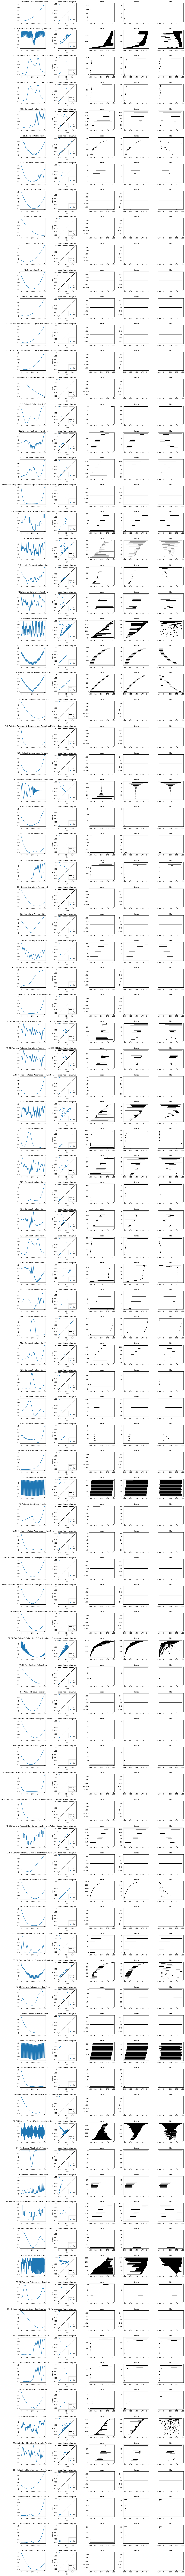

In [7]:
rows = 96
fig, axs = plt.subplots(rows, 5, figsize=(16, int(2.5*rows)))
axs_flat = axs.flatten()
index = 0
for i, function in enumerate(functions):
    try:
        f = function(ndim=2)
        points = generate_points_on_line(f.lb, f.ub, num_points) # sample between upper and lower bound over diagonal
        y = []
        for x in points:
            y.append(f.evaluate(x))
        y = np.array(y)
        y = (y - np.min(y)) / (np.max(y) - np.min(y)) # Scale smaples
        _, _, dgm0 = diagram_points(y)
        axs_flat[index].plot(y)
        axs_flat[index].set_title(f.name)
        max_v = 1.3
        min_v = -0.1
        index +=1
        plot_diagrams(dgm0, ax=axs_flat[index], xy_range=[min_v, max_v, min_v, max_v])
        axs_flat[index].set_title("persistance diagram")
        index +=1
        dgm0[np.isinf(dgm0)] = 1
        for i, (start, end) in enumerate(c1_sort(dgm0)):
            axs_flat[index].plot([start, end], [i, i], color='black')
        axs_flat[index].set_title("birth")
        index +=1
        for i, (start, end) in enumerate(c2_sort(dgm0)):
            axs_flat[index].plot([start, end], [i, i], color='black')
        axs_flat[index].set_title("death")
        index +=1
        for i, (start, end) in enumerate(l_sort(dgm0)):
            axs_flat[index].plot([start, end], [i, i], color='black')
        axs_flat[index].set_title("life")
        axs_flat[index].set_yticklabels([])
        axs_flat[index].set_yticks([])
        index +=1
    except Exception as e:
        pass
        #print(e)
plt.tight_layout()
plt.savefig(f'figures/cec.pdf', bbox_inches='tight', pad_inches=0)